In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [ ]:
# Configure GPU memory growth to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

# Check for GPU availability
tf.keras.mixed_precision.set_global_policy('mixed_float16')

print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters
max_features = 50000  # Size of vocabulary
maxlen = 500  # Maximum sequence length
embedding_dims = 128  # Embedding dimension
batch_size = 128
epochs = 10

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Pad sequences to ensure uniform input size
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Create early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# RNN Model

Training model...

Epoch 1/10
25/25 [==============================] - 25s 911ms/step - loss: 0.6463 - accuracy: 0.6336 - val_loss: 0.5175 - val_accuracy: 0.7917

Epoch 2/10
25/25 [==============================] - 23s 918ms/step - loss: 0.4586 - accuracy: 0.8287 - val_loss: 0.4364 - val_accuracy: 0.8324

Epoch 3/10
25/25 [==============================] - 22s 894ms/step - loss: 0.3625 - accuracy: 0.8705 - val_loss: 0.3965 - val_accuracy: 0.8460

Epoch 4/10
25/25 [==============================] - 23s 907ms/step - loss: 0.2856 - accuracy: 0.9082 - val_loss: 0.3676 - val_accuracy: 0.8507

Epoch 5/10
25/25 [==============================] - 23s 932ms/step - loss: 0.2178 - accuracy: 0.9326 - val_loss: 0.3479 - val_accuracy: 0.8591

Epoch 6/10
25/25 [==============================] - 24s 976ms/step - loss: 0.1725 - accuracy: 0.9502 - val_loss: 0.3697 - val_accuracy: 0.8462

Epoch 7/10
25/25 [==============================] - 26s 1s/step - loss: 0.1281 - accuracy: 0.9656 - val_loss: 0.3786 

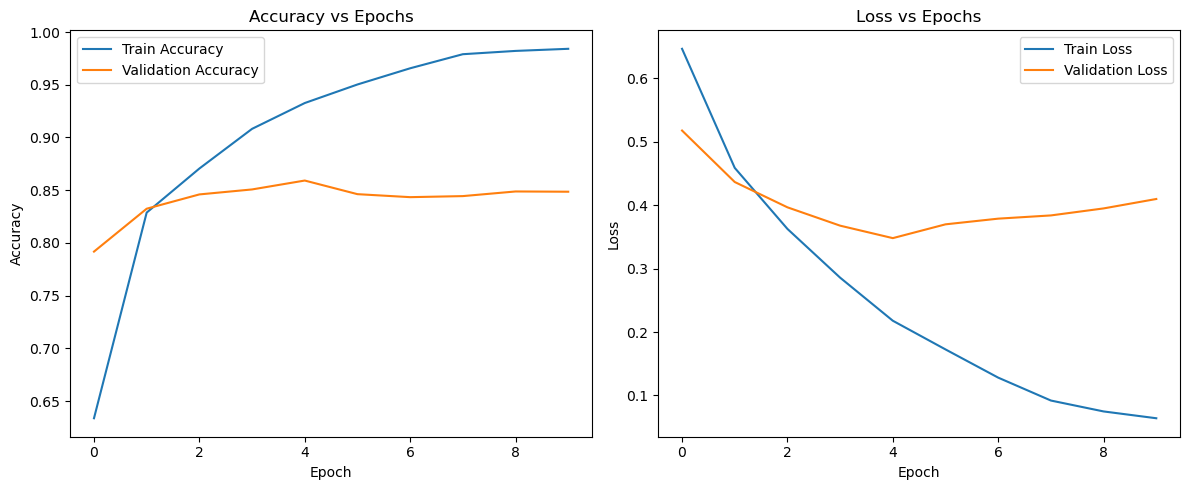

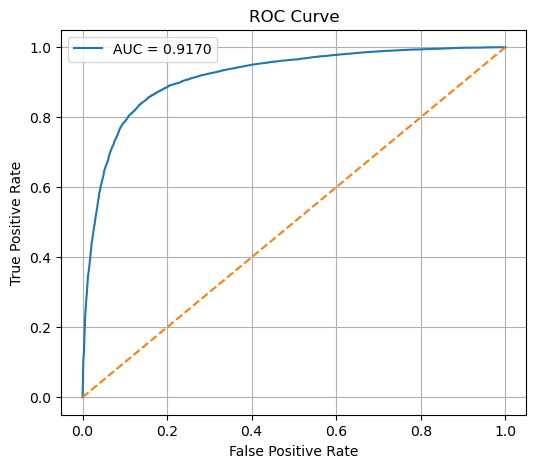

In [3]:
# Build the SimpleRNN model
model = Sequential()
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model.add(SimpleRNN(32, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

# Lists to store metrics during training
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Train the model with custom history tracking
print("Training model...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # Train for one epoch
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=1,
        verbose=1,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping]
    )

    train_loss_hist.append(history.history['loss'][0])
    train_acc_hist.append(history.history['accuracy'][0])
    test_loss_hist.append(history.history['val_loss'][0])
    test_acc_hist.append(history.history['val_accuracy'][0])

# Generate predictions for metrics
y_prob = model.predict(x_test, verbose=0).ravel()
y_pred = (y_prob > 0.5).astype(int)
y_true = y_test

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {test_acc_hist[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Visualizations
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(test_loss_hist, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()



# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# LTSM Model

Training model...
Epoch 1/10
25/25 [==============================] - 8s 119ms/step - loss: 0.6481 - accuracy: 0.6660 - val_loss: 0.4811 - val_accuracy: 0.7922
Epoch 2/10
25/25 [==============================] - 2s 92ms/step - loss: 0.4199 - accuracy: 0.8314 - val_loss: 0.3625 - val_accuracy: 0.8552
Epoch 3/10
25/25 [==============================] - 2s 93ms/step - loss: 0.3010 - accuracy: 0.8884 - val_loss: 0.3903 - val_accuracy: 0.8332
Epoch 4/10
25/25 [==============================] - 2s 95ms/step - loss: 0.2409 - accuracy: 0.9152 - val_loss: 0.3064 - val_accuracy: 0.8749
Epoch 5/10
25/25 [==============================] - 2s 94ms/step - loss: 0.1961 - accuracy: 0.9340 - val_loss: 0.3097 - val_accuracy: 0.8761
Epoch 6/10
25/25 [==============================] - 2s 96ms/step - loss: 0.1761 - accuracy: 0.9401 - val_loss: 0.3104 - val_accuracy: 0.8714
Epoch 7/10
25/25 [==============================] - 2s 91ms/step - loss: 0.1284 - accuracy: 0.9604 - val_loss: 0.3702 - val_accuracy: 0

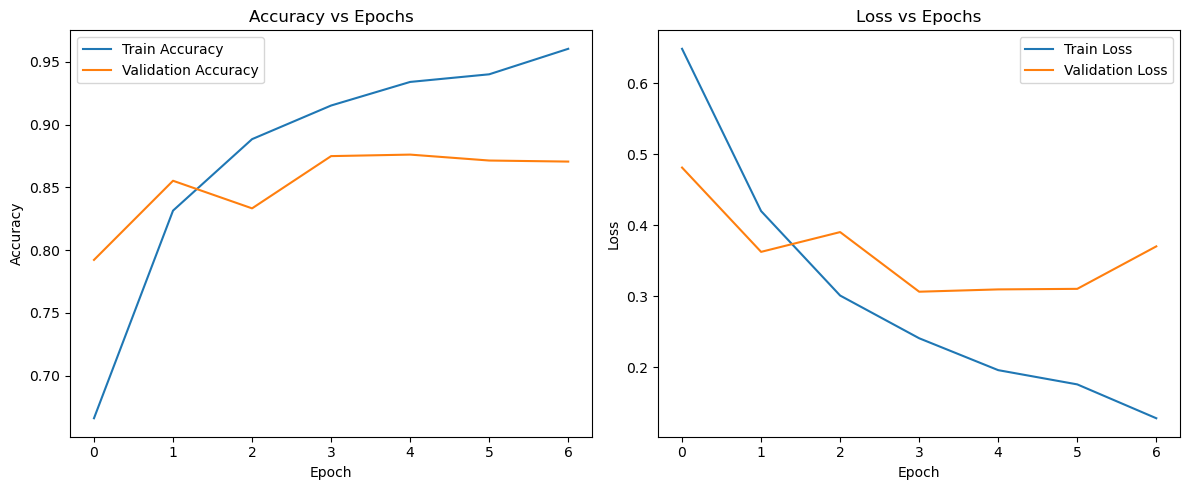

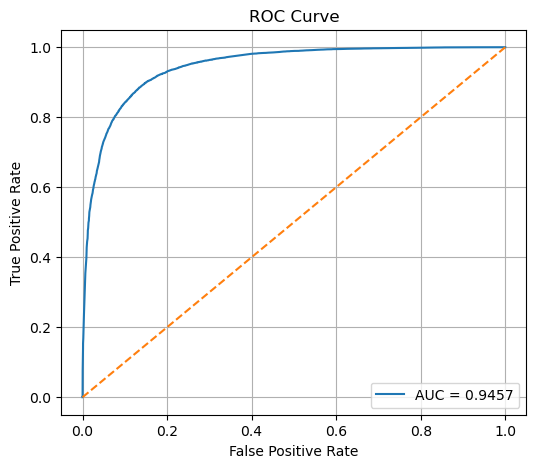

In [4]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model.add(tf.keras.layers.LSTM(32, return_sequences=False))  # Replace SimpleRNN with LSTM
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

# Train the model
print("Training model...")
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Evaluate the model and calculate metrics
y_prob = model.predict(x_test, verbose=0).ravel()
y_pred = (y_prob > 0.5).astype(int)
y_true = y_test

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {history.history['val_accuracy'][-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Visualizations
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


# GRU Model

Training model...
Epoch 1/10
25/25 [==============================] - 7s 114ms/step - loss: 0.6611 - accuracy: 0.6163 - val_loss: 0.5858 - val_accuracy: 0.7052
Epoch 2/10
25/25 [==============================] - 2s 92ms/step - loss: 0.4645 - accuracy: 0.7929 - val_loss: 0.3718 - val_accuracy: 0.8374
Epoch 3/10
25/25 [==============================] - 2s 89ms/step - loss: 0.3055 - accuracy: 0.8732 - val_loss: 0.3343 - val_accuracy: 0.8590
Epoch 4/10
25/25 [==============================] - 2s 92ms/step - loss: 0.2328 - accuracy: 0.9104 - val_loss: 0.5654 - val_accuracy: 0.7618
Epoch 5/10
25/25 [==============================] - 2s 89ms/step - loss: 0.1981 - accuracy: 0.9259 - val_loss: 0.4096 - val_accuracy: 0.8362
Epoch 6/10
25/25 [==============================] - 2s 94ms/step - loss: 0.1712 - accuracy: 0.9371 - val_loss: 0.3570 - val_accuracy: 0.8622
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping

Final Evaluation on Test Set:
Accuracy : 0.8622
Pr

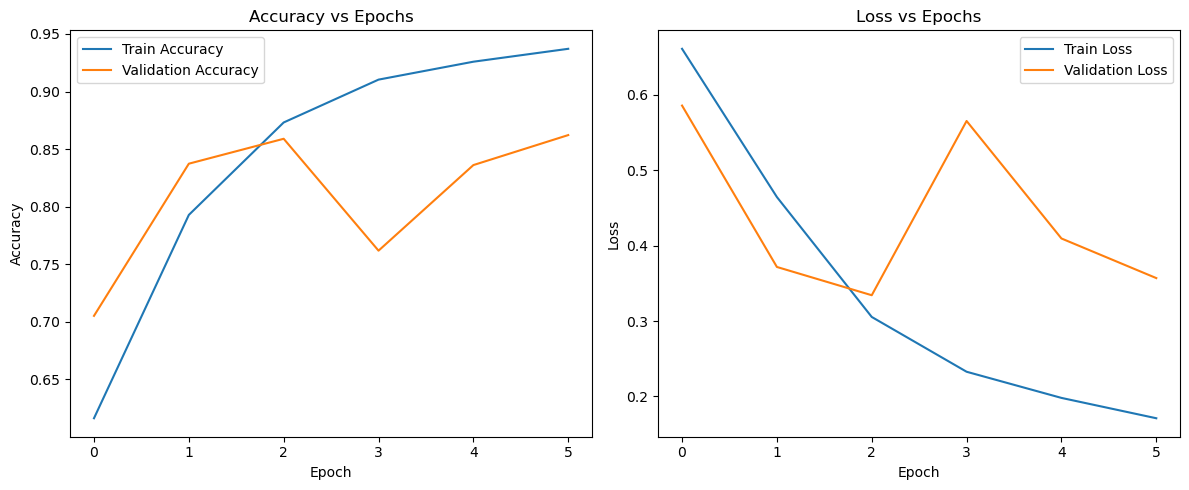

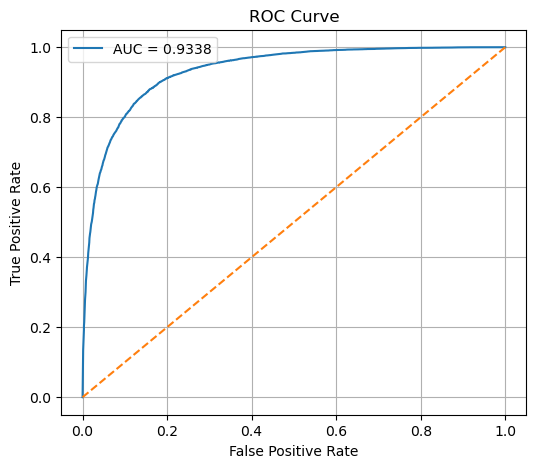

In [5]:
# Build the GRU model
model = Sequential()
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model.add(tf.keras.layers.GRU(32, return_sequences=False))  # Replace SimpleRNN with GRU
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

# Train the model
print("Training model...")
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Evaluate the model and calculate metrics
y_prob = model.predict(x_test, verbose=0).ravel()
y_pred = (y_prob > 0.5).astype(int)
y_true = y_test

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {history.history['val_accuracy'][-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Visualizations
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


# Penjelasan Model, Visualisasi, dan Metrik

## 1. RNN (Recurrent Neural Network)

RNN menggunakan mekanisme **recurrence** untuk mengolah data urut seperti teks atau waktu. Formula utama yang digunakan dalam RNN adalah:

### Persamaan Dasar:
- **State Update**:
  $$
  h_t = f(W_h \cdot h_{t-1} + W_x \cdot x_t + b)
  $$
  - **Penjelasan**:
    - \($h_t$\): State tersembunyi pada waktu \(t\).
    - \($x_t$\): Input saat waktu \(t\).
    - \($W_h$\), \($W_x$\): Matriks bobot untuk state sebelumnya dan input saat ini.
    - \($b$\): Bias.
    - \($f$\): Fungsi aktivasi (contoh: tanh atau ReLU).

### Alur:
Pada setiap langkah waktu, RNN memperbarui state tersembunyi \($h_t$\) menggunakan input saat itu \($x_t$\) dan state sebelumnya \($h_{t-1}$\).

---

## 2. LSTM (Long Short-Term Memory)

LSTM mengatasi masalah **vanishing gradient** yang sering dialami RNN dengan menggunakan **gate mechanism**.

### Persamaan Dasar:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
   $$
   - **Fungsi**: Memutuskan informasi mana yang harus dibuang dari memori.

2. **Input Gate**:
   $$
   i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1}, x_t] + b_C)
   $$
   - **Fungsi**: Menghitung memori baru yang akan ditambahkan.

3. **Cell State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   - **Fungsi**: Memperbarui state sel.

4. **Output Gate**:
   $$
   o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$
   - **Fungsi**: Menghitung keluaran berdasarkan state sel yang diperbarui.

---

## 3. GRU (Gated Recurrent Unit)

GRU adalah versi sederhana dari LSTM tanpa cell state terpisah. Persamaan yang digunakan:

### Persamaan Dasar:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
   $$
   - **Fungsi**: Memutuskan informasi masa lalu yang harus dilupakan.

2. **Update Gate**:
   $$
   z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
   $$
   - **Fungsi**: Mengontrol berapa banyak informasi dari masa lalu yang akan dibawa ke state saat ini.

3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$
   - **Fungsi**: State tersembunyi diperbarui menggunakan reset dan update gate.

---

## 4. Visualisasi

### Akurasi:
Akurasi dihitung sebagai:
$$
\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Sampel}}
$$

### Loss:
Loss dalam pelatihan model dihitung menggunakan fungsi **Binary Cross Entropy (BCE)**:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label sebenarnya.
- \($\hat{y}_i$\): Probabilitas prediksi model.

### ROC Curve:
ROC Curve menunjukkan hubungan antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)**:
- **TPR**:
  $$
  TPR = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$
- **FPR**:
  $$
  FPR = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}
  $$

### AUC (Area Under Curve):
AUC mengukur area di bawah ROC Curve:
$$
\text{AUC} = \int_{0}^{1} TPR(FPR) \,dFPR
$$
Nilai AUC berkisar antara 0 hingga 1, dengan 1 menunjukkan prediksi sempurna.

---

## 5. Metrik

### Precision:
Precision mengukur seberapa tepat model dalam prediksi kelas positif:
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

### Recall:
Recall mengukur kemampuan model untuk mendeteksi semua kelas positif:
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

### F1 Score:
F1 Score adalah rata-rata harmonis antara precision dan recall:
$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

# Penjelasan Matematika TensorFlow (RNN, LSTM, GRU)

## 1. Embedding Layer
Layer **Embedding** digunakan untuk memetakan indeks kata menjadi representasi vektor terdistribusi yang dapat dipelajari:
$$
E(x_t) = W_{embedding} \cdot x_t
$$
- **Dimensi**:
  - \($x_t$\): Input berupa indeks kata, berukuran \($(\text{batch\_size}, \text{sequence\_length})$\).
  - \($W_{embedding}$\): Matriks bobot berukuran \($(\text{vocab\_size}, \text{embed\_dim})$\).
  - Output: Tensor berukuran \($(\text{batch\_size}, \text{sequence\_length}, \text{embed\_dim})$\).

Embedding ini secara otomatis diperbarui selama pelatihan untuk menghasilkan representasi semantik dari kata-kata.

---

## 2. Recurrent Neural Network (RNN)
RNN memproses data sekuensial dengan memanfaatkan hubungan temporal antar elemen.

### Persamaan Dasar:
$$
h_t = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
$$
- **Penjelasan**:
  - \($h_t$\): State tersembunyi pada waktu \($t$\).
  - \($W_{ih}$\): Bobot antara input dan state tersembunyi (\($embed\_dim \to hidden\_dim$\)).
  - \($W_{hh}$\): Bobot antara state tersembunyi sebelumnya (\($hidden\_dim \to hidden\_dim$\)).
  - \($b_h$\): Bias.
  - \($\text{tanh}$\): Fungsi aktivasi untuk mengontrol non-linearitas.

### Bidirectional RNN:
RNN dapat bersifat bidirectional, yang berarti memproses data dalam dua arah (maju dan mundur). Hal ini memungkinkan model untuk menangkap informasi dari konteks sebelum dan sesudah:
$$
h_t^{fwd} = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot h_{t-1}^{fwd} + b_h)
$$
$$
h_t^{bwd} = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot h_{t+1}^{bwd} + b_h)
$$
$$
h_t = [h_t^{fwd}, h_t^{bwd}]
$$
Di kode, RNN diganti dengan `layers.SimpleRNN`.

---

## 3. Long Short-Term Memory (LSTM)
LSTM adalah pengembangan dari RNN yang menggunakan mekanisme gate untuk menangani masalah **vanishing gradient**.

### Persamaan Dasar:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
   $$
   - Mengontrol informasi mana yang harus dilupakan.

2. **Input Gate**:
   $$
   i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1}, x_t] + b_C)
   $$
   - Mengontrol informasi baru yang masuk ke memori.

3. **Cell State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   - Memperbarui state sel.

4. **Output Gate**:
   $$
   o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$
   - Mengontrol keluaran berdasarkan state sel yang diperbarui.

### Bidirectional LSTM:
Sama seperti RNN, LSTM dapat dibuat bidirectional untuk menangkap konteks sekuensial secara penuh.

Di kode, LSTM diimplementasikan menggunakan `layers.LSTM`.

---

## 4. Gated Recurrent Unit (GRU)
GRU adalah versi lebih ringan dari LSTM, dengan mekanisme gate yang lebih sederhana.

### Persamaan Dasar:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_{r} \cdot [h_{t-1}, x_t] + b_{r})
   $$
   - Mengontrol seberapa banyak informasi lama yang dilupakan.

2. **Update Gate**:
   $$
   z_t = \sigma(W_{z} \cdot [h_{t-1}, x_t] + b_{z})
   $$
   - Mengontrol seberapa banyak informasi baru yang ditambahkan.

3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_{h} \cdot [r_t \odot h_{t-1}, x_t] + b_{h})
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$

### Bidirectional GRU:
Bidirectional GRU menggunakan dua GRU, maju dan mundur, untuk memproses data sekuensial:
$$
h_t = [h_t^{fwd}, h_t^{bwd}]
$$
Di kode, GRU diimplementasikan menggunakan `layers.GRU`.

---

## 5. Global Max Pooling
Global Max Pooling mengubah sekuens menjadi representasi tetap:
$$
\text{GlobalMaxPool}(x) = \max(x_t), \forall t
$$
- **Dimensi**:
  - Input: \($(\text{batch\_size}, \text{sequence\_length}, \text{feature\_dim})$\).
  - Output: \($(\text{batch\_size}, \text{feature\_dim})$\).

---

## 6. Dense Layer
Dense layer digunakan untuk transformasi linier:
$$
y_t = W \cdot x_t + b
$$
- \($W$\): Matriks bobot (\($feature\_dim \to 1$\)).
- \($b$\): Bias.

Fungsi aktivasi seperti `sigmoid` digunakan untuk menghasilkan probabilitas:
$$
\hat{y}_t = \sigma(y_t)
$$

---

## 7. Binary Cross-Entropy Loss
Loss dihitung menggunakan:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label benar (0 atau 1).
- \($\hat{y}_i$\): Probabilitas prediksi.

---

## 8. Gradient Clipping
Gradient clipping digunakan untuk menghindari exploding gradients:
$$
\text{Gradient Clipping: } g_i = \min\big(g_i, \text{threshold}\big)
$$
- Memastikan gradient berada dalam batas tertentu.

---